In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


import keras
from tensorflow.keras.layers import Activation, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, LSTM, concatenate
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras import optimizers
from keras.utils import to_categorical
import seaborn as sns

In [2]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/UCI_HAR_Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI_HAR_Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCI_HAR_Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI_HAR_Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCI_HAR_Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [5]:
# Create train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=  y_train)

In [6]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

y_val_array = np.array(y_val)
val_set = np.c_[X_val, y_val_array]

X_train, y_train = split_sequences(train_set, 9)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 9)
print(X_test.shape, y_test.shape)

X_val, y_val = split_sequences(val_set, 9)
print(X_val.shape, y_val.shape)

(5506, 9, 561) (5506,)
(2939, 9, 561) (2939,)
(1830, 9, 561) (1830,)


In [8]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

y_val = to_categorical(y_val)
print(y_val.shape)

(5506, 7)
(2939, 7)
(1830, 7)


In [9]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

9 561 7


In [16]:

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 7, 64)             107776    
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 64)             12352     
                                                                 
 dropout_3 (Dropout)         (None, 5, 64)             0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             23000     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                      

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# fit network
batch_size = 64
validation_split = 0.2
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
69/69 [==============================] - 5s 20ms/step - loss: 1.8345 - accuracy: 0.1880 - val_loss: 1.7924 - val_accuracy: 0.1642
Epoch 2/20
69/69 [==============================] - 1s 10ms/step - loss: 1.7948 - accuracy: 0.1823 - val_loss: 1.7844 - val_accuracy: 0.1751
Epoch 3/20
69/69 [==============================] - 1s 10ms/step - loss: 1.7917 - accuracy: 0.1814 - val_loss: 1.7843 - val_accuracy: 0.1860
Epoch 4/20
69/69 [==============================] - 1s 14ms/step - loss: 1.7907 - accuracy: 0.1817 - val_loss: 1.7869 - val_accuracy: 0.1860
Epoch 5/20
69/69 [==============================] - 1s 10ms/step - loss: 1.7907 - accuracy: 0.1798 - val_loss: 1.7830 - val_accuracy: 0.1860
Epoch 6/20
69/69 [==============================] - 1s 11ms/step - loss: 1.7897 - accuracy: 0.1926 - val_loss: 1.7835 - val_accuracy: 0.1860
Epoch 7/20
69/69 [==============================] - 1s 12ms/step - loss: 1.7898 - accuracy: 0.1842 - val_loss: 1.7814 - val_accuracy: 0.2033
Epoch 8/20
69

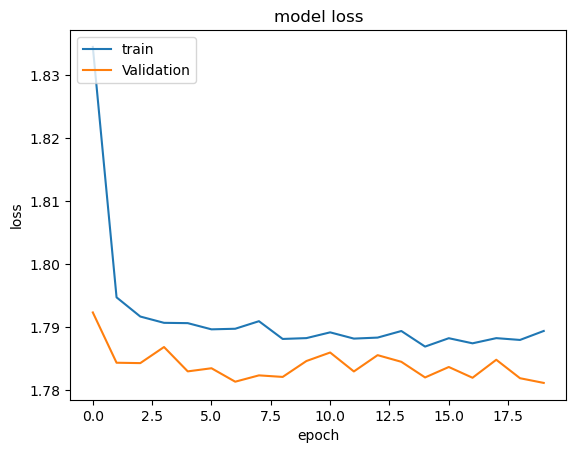

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [20]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(X_test)

Accuracy of the CNN model 0.1782919317483902
92/92 [==============================] - 1s 3ms/step


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[  0   0   0   0 496   0]
 [  0   0   0   0 471   0]
 [  0   0   0   0 420   0]
 [  0   0   0   0 491   0]
 [  0   0   0   0 524   0]
 [  0   0   0   0 537   0]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.00      0.00      0.00       471
           3       0.00      0.00      0.00       420
           4       0.00      0.00      0.00       491
           5       0.18      1.00      0.30       524
           6       0.00      0.00      0.00       537

    accuracy                           0.18      2939
   macro avg       0.03      0.17      0.05      2939
weighted avg       0.03      0.18      0.05      2939



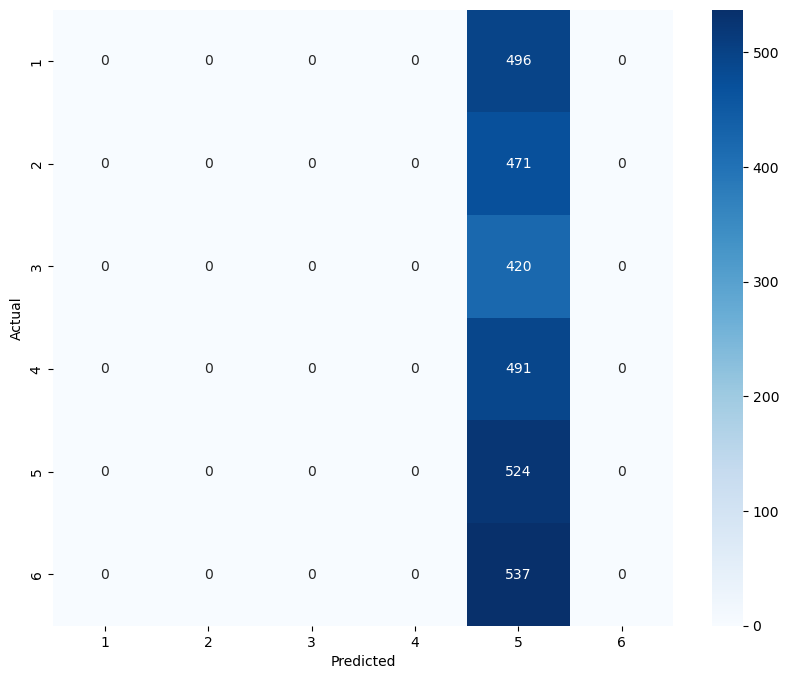

In [23]:
classNames=["1","2","3","4","5","6"]
display_results(y_test,predictions,classNames)